# Example: the EMRI mass function.

In this notebook, we validate a 1-dimensional population Fisher-matrix for the spectral index of the EMRI mass function against numerical MCMC results.

The model is the same used in the [tutorial here](https://github.com/aantonelli94/PopFisher/blob/main/GW_like_examples/tutorial_EMRI_mass_function_no_selectioneffects.ipynb). As a result, the code will not be as heavily commented.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import matplotlib as mpl
import seaborn as sns
import time

import arviz as az
from scipy.special import erfc
from sympy.parsing import mathematica as M


from MCMC_PowerLaw   import * # Import utils to perform the MCMC analysis.
from Fisher_PowerLaw import * # Import utils to calculate the Fisher estimates.


%matplotlib inline
np.random.seed(123)
az.style.use("arviz-darkgrid")


params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

### Generate data

The data are generated in the same way as the tutorial, with a spectral index that is flat in the log of the masses and lower and upper limits $10^4 M_\odot < M < 10^7 M_\odot$.

In [2]:
"""
Parameters
"""

N_obs = 100
N_samps_likelihoods = 10
N_samps_selfunction = 10000 # Needs to be high to sample well the selection function's integral.
                            # but small enough to avoid slowing the Fisher calculation too much.


alpha0_t = 0.00001 # Choose flat spectral profile.
M_min=10000. ;   logM_min = np.log(M_min) # M runs from 10^4
M_max=10000000.; logM_max = np.log(M_max) # to 10^7 solar masses.

The analytical inversion of the power-law to get samples for the masses has been coded up in the $\texttt{log_M()}$ function. See the [tutorial](https://github.com/aantonelli94/PopFisher/blob/main/GW_like_examples/tutorial_EMRI_mass_function_no_selectioneffects.ipynb) for more details as to how this is done.


In [3]:
"""
Noise characteristics.
"""

sigma = 0.1
dth = 13.0
noise = np.random.normal(0,sigma,size = N_obs)

"""
Data draws.
"""

u = np.random.uniform(size=N_obs)
logM_t=log_M(alpha0_t, N_obs, M_max,M_min)
d_i = noise + logM_t  # observations made of noise + true population.
d_i_selbias = d_i[d_i>dth]
N_det = len(d_i_selbias)

print('Out of', N_obs,'possible events,', N_det,'are detected.')

"""
Data array. The structure of data is such that Data[i,j] is the jth posterior sample from event i.
We assume the observation model p(d|theta) is a normal gaussian with noise variance sigma.

"""

logM_obs_selbias=np.zeros((N_det,N_samps_likelihoods))
for i in np.arange(N_det):
    logM_obs_selbias[i,:]=np.random.normal(d_i_selbias[i],sigma,size=N_samps_likelihoods)
data = logM_obs_selbias


Out of 100 possible events, 39 are detected.


Plot the true and observed populations. If a threshold lower than the lower limit of integration in the masses has been chosen, the two populations will be clearly distinguishable.

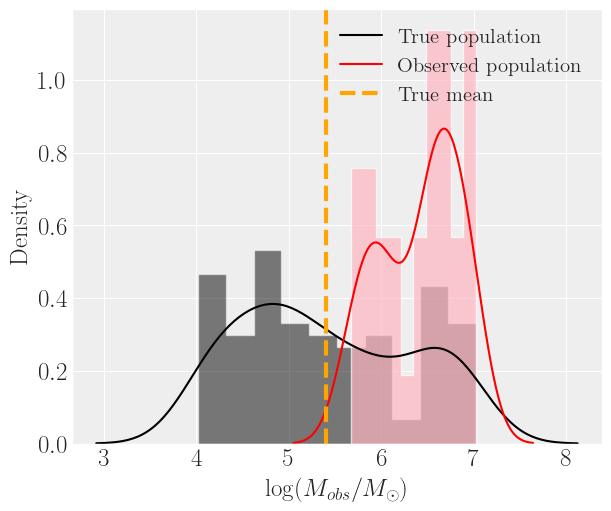

In [4]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plt.hist(np.log10(np.exp(d_i)),density=True,bins=10,histtype = 'stepfilled',
                               color ='black', alpha=0.5, edgecolor='white')
sns.kdeplot(np.array(np.log10(np.exp(d_i))), label='True population',c='k')
plt.hist(np.log10(np.exp(d_i_selbias)),density=True,bins=10,histtype = 'stepfilled',
                            color ='lightpink', alpha=0.7, edgecolor='white')
sns.kdeplot(np.array(np.log10(np.exp(d_i_selbias))), label='Observed population',c='red')
    
plt.axvline(x=np.log10(np.exp(np.mean(logM_t))), label='True mean', c='orange',ls='--',lw=3)

plt.xlabel('$\log(M_{obs}/M_\odot)$')
plt.ylabel('Density')
plt.legend()

### Fitting

We fit the population likelihood here assuming flat gaussian priors on $\alpha$. Notice that the relevant function for the log_likelihood-- "log_likelihood()" -- is found in MCMC_PowerLaw.py. The argument it requires are fed into the args option in the "EnsembleSampler".

Notice that the "log_likelihood()" function takes into account selection effects. These are obtained solving the following integral with Monte Carlo methods,

  $$p_\text{det}(\lambda) = \int p_\text{det}(\theta) p(\theta|\lambda) d\theta \approx \frac{1}{N_\text{samp}}\sum \frac{p_\text{det}(\theta_{ij})}{2}\text{erfc}\left[\frac{d_\text{th}-\theta_{ij}}{\sqrt{2}\sigma}\right]\quad (\text{with } \theta_{ij}\sim p(\theta|\lambda)).$$

This integration is performed in the "selection_function" function called by "log_likelihood()".

In [5]:
# Limits of (flat) hyperpriors.

hyperprior_min = -100.0
hyperprior_max = 100.0

# Iterations, ndims and walkers.

n_iter = 30000
ndim = 1; nwalkers = 4

# Initialization of the MCMC. Perturb away from true values.

pos_init0 = [alpha0_t]
p0 = pos_init0*(1+0.001* np.random.randn(nwalkers, ndim))

# Sampling

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood,
                                args=[data,hyperprior_min,hyperprior_max,
                                      N_samps_selfunction, M_max, M_min, sigma, dth, N_det]
                               )



run = sampler.run_mcmc(p0, n_iter, progress=True)

100%|████████████████████████████████████| 30000/30000 [01:50<00:00, 270.57it/s]


In [6]:
# Error on hyperparameter from MCMC.
alpha_samples_emcee = sampler.get_chain(discard=2000, thin=1, flat=False)
print('Error:',np.sqrt(np.var(alpha_samples_emcee)))

Error: 0.18335640153054675


### MCMC results and diagnostics

We run some diagnostics using the arviz package. We gather some interactive data from emcee's results with the following lines.

In [7]:
# define variable names, it cannot be inferred from emcee
var_names = ["alpha"]
burnin = 1000


idata1 = az.from_emcee(sampler, var_names=var_names) # interactive data.
idata2 = idata1.sel(draw=slice(burnin, None), groups="posterior") # interactive data.

Mean and variance from interactive data.

In [8]:
print('Mean:',idata2.posterior.mean())
print('Variance:',idata2.posterior.var())

Mean: <xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 0.2491
Variance: <xarray.Dataset>
Dimensions:  ()
Data variables:
    alpha    float64 0.03356


We check the summary statistics and plot trace and posterior here

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.2491,0.1832,-0.0917,0.5958,0.0031,0.0022,3496.6252,9332.3147,1.0014


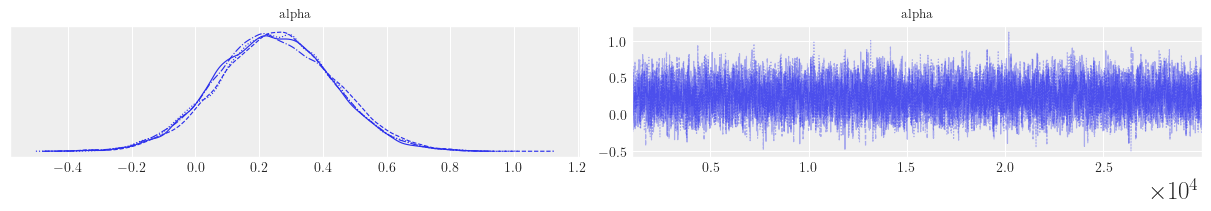

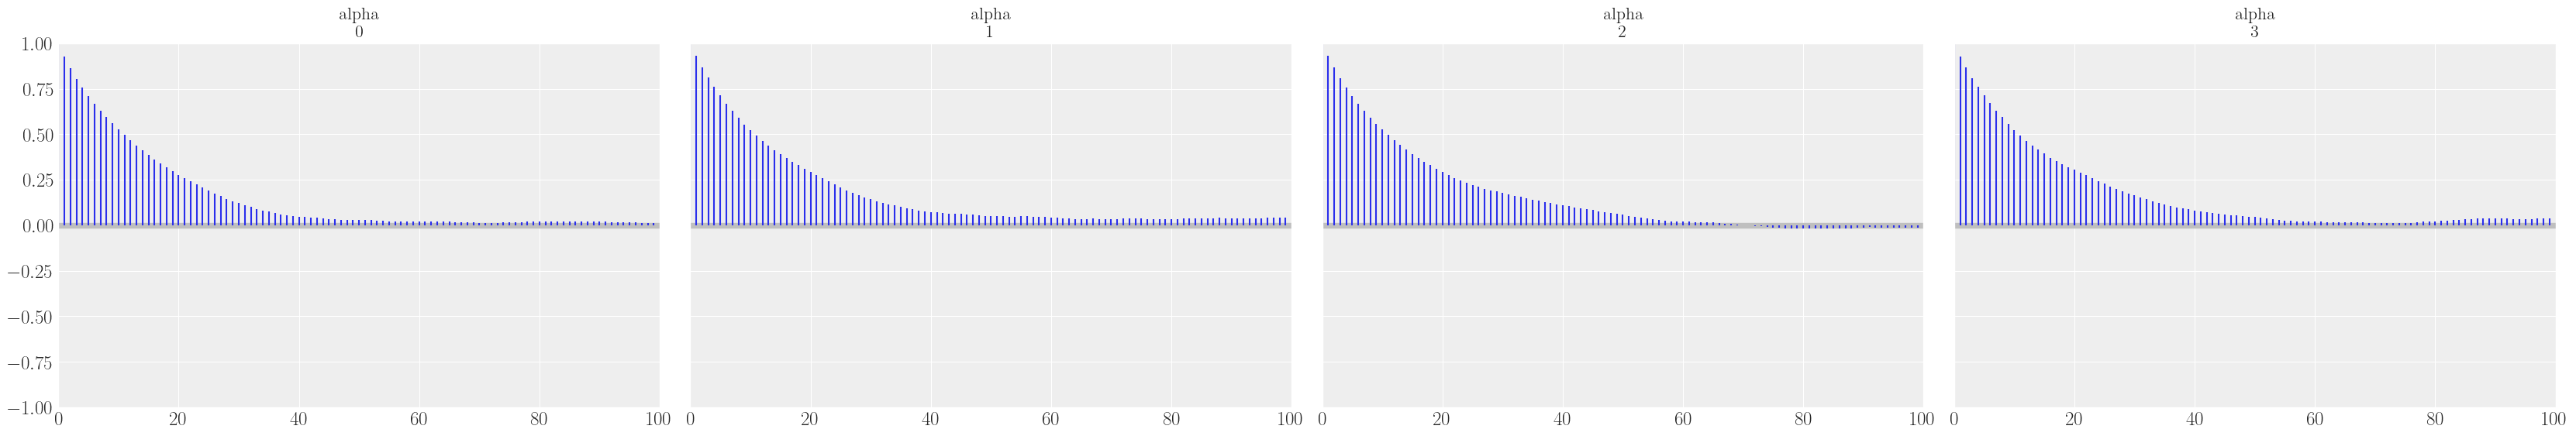

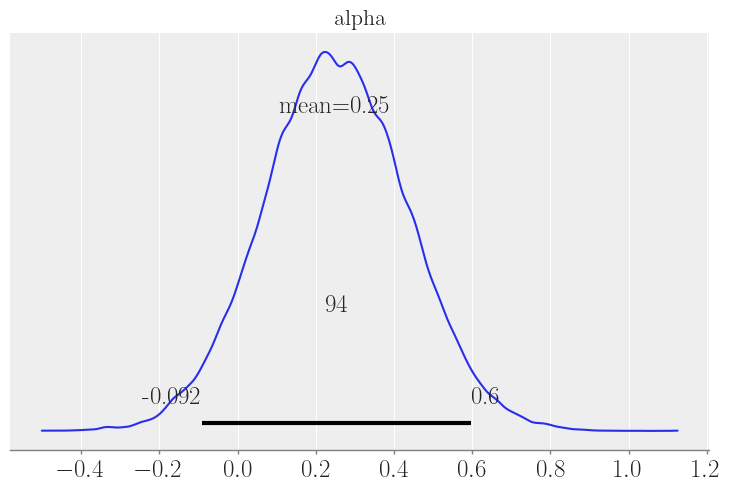

In [9]:
display(az.summary(idata2, round_to=4))         # Summary statistics.
az.plot_trace(idata2, var_names=var_names);     # Plot traces.
az.plot_autocorr(idata2, var_names=var_names);  # Plot autocorrelation.
az.plot_posterior(idata2, var_names=var_names); # Plot posterior distribution.

It is useful to single out the samples for the parameter of interest, which is done as follows:

In [10]:
#Get samples for parameter
stacked = idata1.posterior.stack(draws=("chain", "draw"))
alpha_samples=stacked.alpha.values

Plot the KDE.

/var/folders/kn/pfvkpzns1_39c74mvcrv9p1r0000gn/T/ipykernel_25731/3611444380.py:27: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.gcf().tight_layout()


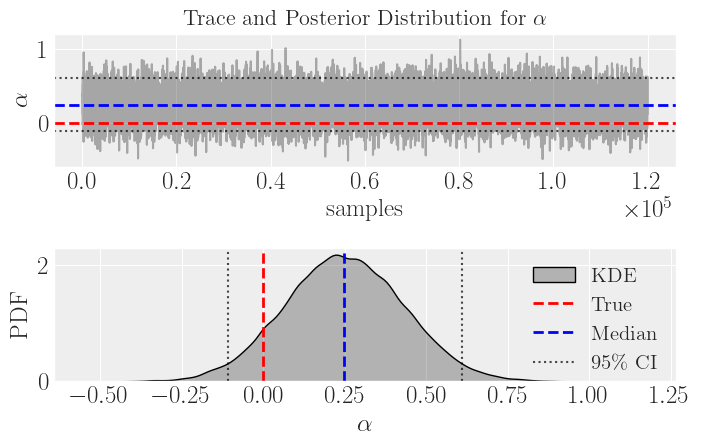

In [11]:
# Get the credible interval, mean and median.
cred_min, cred_max = np.percentile(alpha_samples, 2.5), np.percentile(alpha_samples, 97.5)
median=np.median(alpha_samples)

# Plot Trace
plt.subplot(2,1,1)
plt.plot(alpha_samples,color='k',alpha=0.3)
plt.xlabel('samples')
plt.ylabel(r'$\alpha$')
plt.axhline(alpha0_t, color='r', lw=2, linestyle='--')
plt.axhline(median, color='blue', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.7)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.7)
plt.title('Trace and Posterior Distribution for {}'.format(r'$\alpha$'))

# Plot KDE
plt.subplot(2,1,2)
sns.kdeplot(alpha_samples, shade=True, color='k',label='KDE')
plt.xlabel(r'$\alpha$')
plt.ylabel('PDF')
plt.axvline(alpha0_t, color='r', lw=2, linestyle='--',label='True')
plt.axvline(median, color='blue', lw=2, linestyle='--',label='Median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.7, label=r'$95\%$ CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.7)
  
# Final touches.
plt.gcf().tight_layout()
plt.legend()

### Fisher estimates

This expressions has been coded up for a mono-parametric (but generic) power-law model in the function "FM_1D_powerlaw" function below, which is found in Fisher_PowerLaw.py.

Details as to how this is calculated and implemented are reported in [this note](https://github.com/aantonelli94/PopFisher/blob/main/GW_like_examples/Notes_1D_FM_PowerLaw.ipynb).

In [12]:
#samples drawn from PDF to be used in the Monte Carlo integral.
theta_ij = log_M(alpha0_t,N_samps_selfunction,M_max,M_min) 

# Call the Fisher matrix function here.
gamma_lambda = FM_1D_powerlaw(theta_ij,alpha0_t,M_max,M_min,sigma,dth,N_samps_selfunction,N_det)
print('Gamma_lambda:', gamma_lambda)

------------------------------------------------
The first term in the FM takes 36 s to evaluate
First integral: 31.924198150635394
------------------------------------------------
The second term in the FM takes 49 s to evaluate
Second integral: -0.0023720811916468905
------------------------------------------------
The third term in the FM takes 55 s to evaluate
Third integral: -0.009680061428738906
------------------------------------------------
The fourth term in the FM takes 61 s to evaluate
Fourth integral: 1.936206675906062e-06
------------------------------------------------
The fifth term in the FM takes 48 s to evaluate
Fifth integral: -0.001858969591162078
------------------------------------------------
Gamma_lambda: 31.91028897463053


Finally, plot the Fisher estimate against the MCMC posterior below.

/var/folders/kn/pfvkpzns1_39c74mvcrv9p1r0000gn/T/ipykernel_25731/2436461426.py:34: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.gcf().tight_layout()


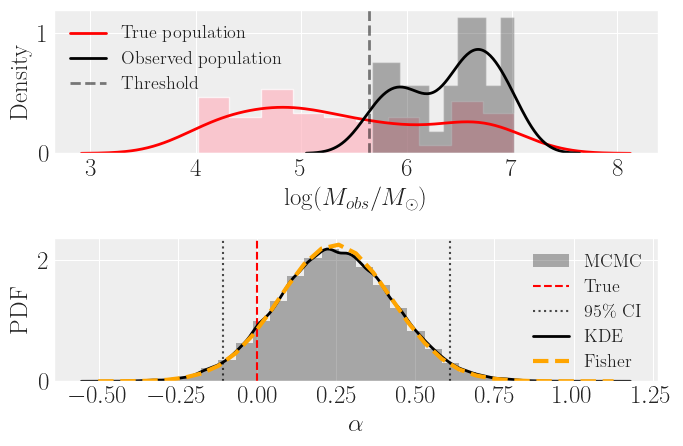

In [13]:
# Plot true and observed populations.

plt.subplot(2,1,1)
plt.hist(np.log10(np.exp(d_i)),density=True,bins=10,histtype = 'stepfilled',
                               color ='lightpink', alpha=0.7, edgecolor='white')
plt.hist(np.log10(np.exp(d_i_selbias)),density=True,bins=10,histtype = 'stepfilled',
                            color ='black', alpha=0.3, edgecolor='white')

sns.kdeplot(np.array(np.log10(np.exp(d_i))), label='True population',c='red',lw=2)
sns.kdeplot(np.array(np.log10(np.exp(d_i_selbias))), label='Observed population',c='k',lw=2)
plt.axvline(x=np.log10(np.exp(dth)), label='Threshold', c='k',alpha=0.5,ls='--',lw=2)

plt.xlabel('$\log(M_{obs}/M_\odot)$')
plt.ylabel('Density')
plt.legend(loc=2,prop={'size': 13})


# Plot distribution
plt.subplot(2,1,2)
plt.hist(alpha_samples, 30, density=True,color='k',alpha=0.3,label='MCMC')
plt.xlabel(r'$\alpha$')
plt.ylabel('PDF')
plt.axvline(alpha0_t, color='r',  linestyle='--',label='True')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.7, label=r'$95\%$ CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.7)
sns.kdeplot(alpha_samples, shade=False, color='k', lw=2, label='KDE')

# Plot Fisher matrix
_, bins_alpha, _= plt.hist(alpha_samples, 30, density=True, alpha=0.0)
Da=np.sqrt(1/gamma_lambda)
plt.plot(np.array(bins_alpha), gaussian(np.array(bins_alpha),np.median(bins_alpha)-0.065,Da**2), color='orange', ls='dashed', lw=3, label='Fisher')

plt.legend(loc=1,prop={'size': 13})
plt.gcf().tight_layout()
plt.savefig('popfish_examples.pdf')